# **Importing the libraries**

In [ ]:
import pandas as pd
import json
from google.colab import drive
from sklearn.model_selection import train_test_split
import random
import re
import numpy as np
import torch.nn as nn
import torch.cuda
import torch
import torch.nn.functional as F
import warnings
import nltk
from nltk.util import ngrams
from matplotlib import pyplot as plt
from nltk import word_tokenize, FreqDist
warnings.filterwarnings('ignore')

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# **Mounting the drive**

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


# **Importing the dataset**

In [ ]:
data = pd.read_json('drive/My Drive/NLP/raw_transcripts.json', orient='index')
transcripts = data["transcript"].tolist()
print("Total number of transcripts: ", len(transcripts))

Total number of transcripts:  1455


In [ ]:
# We are using random 50 transcripts from 1455 for the Model because each trascript size is big with around 30000 words.
totalCount = 50

In [ ]:
randomTranscripts = random.sample(transcripts, totalCount)
trainTranscripts, testTranscripts = train_test_split(randomTranscripts, test_size = 0.3, random_state = 0)

print("Length of the train dataset: ", len(trainTranscripts))
print("Length of test dataset: ", len(testTranscripts))

Length of the train dataset:  35
Length of test dataset:  15


# **Cleaning and Pre-Processing the Data**

In [ ]:
#Changes all transcripts to lowercase to improve the model accuracy and to maintain cosistency.
trainTranscripts = [transcript.lower() for transcript in trainTranscripts]

#Removing all punctuation expect " ' " so to concentrate improve the accuracy of the model 
trainTranscripts = [re.sub("[^a-z ' ]", " ", i) for i in trainTranscripts]

# Sample of Records used in the Model:
print("The sample of Data is as follows:")
print(trainTranscripts[0])
print(trainTranscripts[1])

The sample of Data is as follows:
the steelers now are spreading out they're going to be kicking against a    to    mile an hour wind roy gerela number    has had an erratic kicking year on field gold when he hits it right on the kickoff he can drive it to the goal line or in the end zone i don't think he will against this win and now the cowboys are spreading out in receiving formation they're going to have butch johnson number    and larry brinson number    is their deep men they're on the oneyard line the steelers in drafting this year when after improvement of their specialty team and they did punting team's kicking teams and the entire kicking game and super bowl    is underway the kick is hitting on the    johnson's up with it for the    he is hit down there by number    dirt winston so we'll take a look now as the cowboys go to the attack and this attack design there they are staubach new house dorsett you know mall there the wide receivers hill pearson billy joe dupree first do

In [ ]:
# Counting the words and their frequency in the dataset
words = []
for sent in trainTranscripts:
    for w in word_tokenize(sent):
        words.append(w)
len(words)
fd = FreqDist()
for w in words:
  fd[w] += 1
ranks = []
freqs = []
count = 0;
for temp in fd.most_common():
  count +=1
  ranks.append(count)
  freqs.append(temp[1])

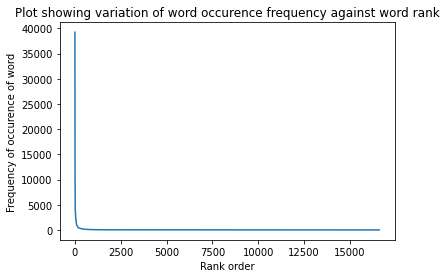

Text(0, 0.5, 'Log frequency of word')

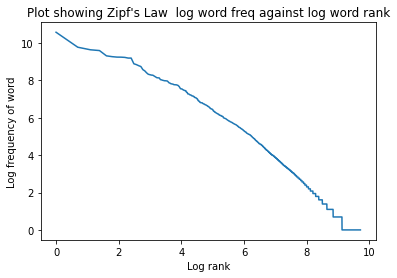

In [ ]:
# plotting graphs againt word and their frequency to validate Zipf's Law
plt.plot(ranks, freqs)
plt.title("Plot showing variation of word occurence frequency against word rank")
plt.xlabel("Rank order")
plt.ylabel("Frequency of occurence of word")
# plt.savefig('FrquencyVsRank.png')
plt.show()
# plt.clf()
plt.plot(np.log(ranks), np.log(freqs))
plt.title("Plot showing Zipf's Law  log word freq against log word rank")
plt.xlabel("Log rank")
plt.ylabel("Log frequency of word")
# plt.savefig('LogFrequencyVsLogRank.png')

In [ ]:
# Function to get  fixed length sequences
def get_fixed_sequence(text, seq_len = 5):
  sequences = []
  words = text.split()
  if len(words) > seq_len:
    for i in range(seq_len, len(words)):
      seq_list = words[i-seq_len: i]
      sequences.append(" ".join(seq_list))
  else:
    sequences = words
  return sequences

In [ ]:
output = [get_fixed_sequence(transcript) for transcript in trainTranscripts]

In [ ]:
length = 0
for i in output:
  length+=len(i)
print("Length of the Fixed length sequences: ", length)

Length of the Fixed length sequences:  607879


In [ ]:
output = sum(output, [])

In [ ]:
# Generating input and target sequences x and y
x = []
y = []
for seq in output:
  words = seq.split()
  x.append(" ".join(words[:-1]))
  y.append(" ".join(words[1:]))

In [ ]:
x[0], y[0]

('the steelers now are', 'steelers now are spreading')

In [ ]:
# Logic to generate integer to token mapping
int_to_token = {}
cnt = 0

for w in set(" ".join(trainTranscripts).split()):
  int_to_token[cnt] = w
  cnt+= 1

# Logic to generate token to integer mapping
token_to_int = {t: i for i, t in int_to_token.items()}

In [ ]:
vocab_size = len(int_to_token)
print("Number of Unique Tokens(Vocabulary Size): ", vocab_size)

Number of Unique Tokens(Vocabulary Size):  17257


In [ ]:
# Function to generate integer sequences
def get_int_seq(seq):
  return [token_to_int[w] for w in seq.split()]

# convert text sequences to integer sequences
x_int = [get_int_seq(i) for i in x]
y_int = [get_int_seq(i) for i in y]

# convert lists to numpy arrays
x_int = np.array(x_int)
y_int = np.array(y_int)


In [ ]:
# Function to create batches from the input data
def get_batches(arr_x, arr_y, batch_size):
  prev = 0
  for n in range(batch_size, arr_x.shape[0], batch_size):
    x = arr_x[prev:n]
    y = arr_y[prev:n]
    prev = n
    yield x,y

# **Building LSTM Model**

RNN is recurrent in nature as it performs the same function for every input of data while the output of the current input depends on the past one computation. In RNN, all the inputs are related to each other.
This makes them applicable to tasks such as Language generation and Machine Translation. Long Short-Term Memory (LSTM) networks are a modified version of RNN, this makes it easier to remember history data in memory. The vanishing gradient problem of RNN is resolved here. LSTM model is well-suited to classify, process and predict data. It trains the model by using back-propagation. Hence this model is best suited for our project.

In [ ]:
class WordLSTM(nn.Module):
    
    def __init__(self, n_hidden=256, n_layers=4, drop_prob=0.3, lr=0.001):
        super().__init__()

        self.drop_prob = drop_prob
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.lr = lr
        
        self.emb_layer = nn.Embedding(vocab_size, 200)

        # define the LSTM
        self.lstm = nn.LSTM(200, n_hidden, n_layers, 
                            dropout=drop_prob, batch_first=True)
        
        # define a dropout layer
        self.dropout = nn.Dropout(drop_prob)
        
        # define the fully-connected layer
        self.fc = nn.Linear(n_hidden, vocab_size)      
    
    def forward(self, x, hidden):
        ''' Forward pass through the network. 
            These inputs are x, and the hidden/cell state `hidden`. '''

        # pass input through embedding layer
        embedded = self.emb_layer(x)     
        
        # Get the outputs and the new hidden state from the lstm
        lstm_output, hidden = self.lstm(embedded, hidden)
        
        # pass through a dropout layer
        out = self.dropout(lstm_output)
        
        # out = out.contiguous().view(-1, self.n_hidden) 
        out = out.reshape(-1, self.n_hidden) 

        # put "out" through the fully-connected layer
        out = self.fc(out)

        # return the final output and the hidden state
        return out, hidden
    
    
    def init_hidden(self, batch_size):
        ''' initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x n_hidden,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data

        # if GPU is available
        if (torch.cuda.is_available()):
          hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda(),
                    weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda())
        
        # if GPU is not available
        else:
          hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_(),
                    weight.new(self.n_layers, batch_size, self.n_hidden).zero_())
        
        return hidden

In [ ]:
# instantiate the model
net = WordLSTM()

# push the model to GPU (avoid it if you are not using the GPU)
net.cuda()

print(net)

WordLSTM(
  (emb_layer): Embedding(17257, 200)
  (lstm): LSTM(200, 256, num_layers=4, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=17257, bias=True)
)


In [ ]:
# Initializing a list to calculate the loss values 
loss_vals =  []
def train(net, epochs=10, batch_size=32, lr=0.001, clip=1, print_every=32):
    
    # optimizer
    opt = torch.optim.Adam(net.parameters(), lr=lr)
    
    # loss
    criterion = nn.CrossEntropyLoss()
    
    # push model to GPU
    net.cuda()
    
    counter = 0

    net.train()

    for epoch in range(epochs):

        # initialize hidden state
        h = net.init_hidden(batch_size)
        
        # initializing epochs loss in each iteration
        epoch_loss= []

        for x, y in get_batches(x_int, y_int, batch_size):
            counter+= 1
            
            # # convert numpy arrays to PyTorch arrays
            inputs, targets = torch.from_numpy(x), torch.from_numpy(y)
            # inputs, targets = x,y
            
            # push tensors to GPU
            inputs, targets = inputs.cuda(), targets.cuda()

            # detach hidden states
            h = tuple([each.data for each in h])

            # zero accumulated gradients
            net.zero_grad()
            
            # get the output from the model
            output, h = net(inputs, h)
            
            # calculate the loss and perform backprop
            loss = criterion(output, targets.view(-1))

            # back-propagate error
            loss.backward()

            # appending the loss item to the initialized epoch loss
            epoch_loss.append(loss.item())

            # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            nn.utils.clip_grad_norm_(net.parameters(), clip)

            # update weigths
            opt.step()            
            
            if counter % print_every == 0:
            
              print("Epoch: {}/{}...".format(epoch+1, epochs),
                    "Step: {}...".format(counter))
        # Appending the average epoch loss after each iteration      
        loss_vals.append(sum(epoch_loss)/len(epoch_loss))

In [ ]:
#Training the LSTM model
train(net, batch_size = 32, epochs=20, print_every=512)

Epoch: 1/20... Step: 512...
Epoch: 1/20... Step: 1024...
Epoch: 1/20... Step: 1536...
Epoch: 1/20... Step: 2048...
Epoch: 1/20... Step: 2560...
Epoch: 1/20... Step: 3072...
Epoch: 1/20... Step: 3584...
Epoch: 1/20... Step: 4096...
Epoch: 1/20... Step: 4608...
Epoch: 1/20... Step: 5120...
Epoch: 1/20... Step: 5632...
Epoch: 1/20... Step: 6144...
Epoch: 1/20... Step: 6656...
Epoch: 1/20... Step: 7168...
Epoch: 1/20... Step: 7680...
Epoch: 1/20... Step: 8192...
Epoch: 1/20... Step: 8704...
Epoch: 1/20... Step: 9216...
Epoch: 1/20... Step: 9728...
Epoch: 1/20... Step: 10240...
Epoch: 1/20... Step: 10752...
Epoch: 1/20... Step: 11264...
Epoch: 1/20... Step: 11776...
Epoch: 1/20... Step: 12288...
Epoch: 1/20... Step: 12800...
Epoch: 1/20... Step: 13312...
Epoch: 1/20... Step: 13824...
Epoch: 1/20... Step: 14336...
Epoch: 1/20... Step: 14848...
Epoch: 1/20... Step: 15360...
Epoch: 1/20... Step: 15872...
Epoch: 1/20... Step: 16384...
Epoch: 1/20... Step: 16896...
Epoch: 1/20... Step: 17408...


Text(0.5, 1.0, 'Loss function of the model')

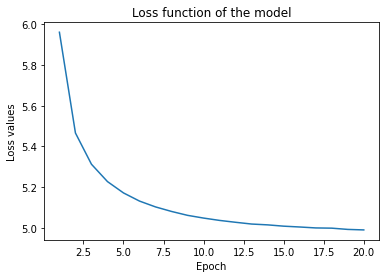

In [ ]:
# Generating a plot for the calculated loss values 
epochs = list(range(1,21))
plt.plot(epochs, loss_vals)
plt.xlabel("Epoch")
plt.ylabel("Loss values")
plt.title("Loss function of the model")
# plt.savefig('Lossfunction.png')

# **Natural Language Generation using LSTM model**

In [ ]:
def predict(net, token, hidden=None):
         
  # tensor inputs
  x = np.array([[token_to_int[token]]])
  inputs = torch.from_numpy(x)
  
  # push to GPU
  inputs = inputs.cuda()

  # detach hidden state from history
  hidden = tuple([each.data for each in hidden])

  # get the output of the model
  out, hidden = net(inputs, hidden)

  # get the token probabilities
  probability = F.softmax(out, dim=1).data

  probability = probability.cpu()

  probability = probability.numpy()
  probability = probability.reshape(probability.shape[1],)

  # get indices of top 3 values
  top_n_idx = probability.argsort()[-3:][::-1]

  # randomly select one of the three indices
  sampled_token_index = top_n_idx[random.sample([0,1,2],1)[0]]

  # return the encoded value of the predicted char and the hidden state
  return int_to_token[sampled_token_index], hidden

In [ ]:
# function to generate text
def generateText(net, size, prime='today'):
        
    # push to GPU
    net.cuda()
    
    net.eval()

    # batch size is 1
    h = net.init_hidden(1)

    tokens = prime.split()

    # predict next token
    for t in prime.split():
      token, h = predict(net, t, h)
    
    tokens.append(token)

    # predict subsequent tokens
    for i in range(size-1):
        token, h = predict(net, tokens[-1], h)
        tokens.append(token)

    return ' '.join(tokens)

In [ ]:
# Generating a random sentence of length 20 words
randomSentence = generateText(net, 20)

print(randomSentence)

today the first half the first down and he has a chance for a touchdown pass but the falcons are in


In [ ]:
# Generating a sentence of length 20 using a prefixed keyword 
prefixSentence = generateText(net, 20, prime = "they")

print(prefixSentence)

they have a chance for that first and goal at their yard line and he was a little slow not going


# **LSTM Model Metrics**

We are using BLEU and ROUGE as model evaluation metrics.

BLEU, Bilingual Evaluation Understudy, is a score used to compare a candidate translation of text to one or more reference translations. The more the matches, the better the candidate translation is. It can be used to evaluate text generated for a suite of natural language processing tasks. This score is used for evaluating the predictions made by automatic machine translation systems. The BLEU score provides an overall assessment of model quality. We have chosen this metric for the following reasons:
It is quick and inexpensive to calculate.
It is easy to understand.
It is language independent.
It correlates highly with human evaluation.
It has been widely adopted

ROUGE (Recall-Oriented Understudy Gisting Evaluation) is a recall-based evaluation metric. Recall measures how much of the reference summary is captured within the generated summary. 
We have used ROUGE-1 and ROUGE-L while evaluating results. ROUGE-1 focuses on unigram ROUGE evaluation, ROUGE-L measures the “longest common subsequence” (LCS) of words due to the assumption that the longer the matching sequence, the closer the summaries.
Precision captures the extent to which the content of the generated text is actually needed. The precision and recall scores are combined by the F1-score which is the harmonic mean of both results.

In [ ]:
# Generating a Bleu Score for a random transcript using first 60 words of the transcript
# Comparing the last 30 words(l30) and generated 30(g30) words using the first 30 words of the transcript(f30)
tran4 = random.choice(trainTranscripts)
tran4words = tran4.split()
f30 = tran4words[0:30]
l30 = tran4words[30:60]
gensent = generateText(net, 30, prime =  " ".join(f30))
g30 = gensent.split()

In [ ]:
# Calculated the Bleu score using sentence bleu package
from nltk.translate.bleu_score import sentence_bleu
reference = [l30]
candidate = g30
score = sentence_bleu(reference, candidate)
print(score)

0.2245483208776255


In [ ]:
pip install rouge

In [ ]:
pip install rouge_score

In [ ]:
# Generating Rogue score by comparing the last 30 words(l30) and generated 30(g30) words using the first 30 words of the transcript(f30)
from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
scores = scorer.score(" ".join(l30)," ".join(g30))
print(scores)

{'rouge1': Score(precision=0.15, recall=0.3, fmeasure=0.2), 'rougeL': Score(precision=0.11666666666666667, recall=0.23333333333333334, fmeasure=0.15555555555555559)}


In [ ]:
pip install rouge

In [ ]:
# Generating Rogue score by comparing the last 30 words(l30) and generated 30(g30) words using the first 30 words of the transcript(f30)
from rouge import Rouge 

hypothesis = " ".join(l30)
reference = " ".join(g30)

rouge = Rouge()
scores = rouge.get_scores(hypothesis, reference)
print(scores)

[{'rouge-1': {'f': 0.19999999555555567, 'p': 0.3, 'r': 0.15}, 'rouge-2': {'f': 0.022727268308368628, 'p': 0.034482758620689655, 'r': 0.01694915254237288}, 'rouge-l': {'f': 0.1643835568549448, 'p': 0.20689655172413793, 'r': 0.13636363636363635}}]


In [ ]:
# Defining a function to calculate the Bleu and Rouge scores for a list of test transcripts
from rouge import Rouge
def generateBleuScores(data):
  bleu_data=[]
  rouge_data=[]
  for transcript in data:
    # print(transcript)
    tran4words = tran4.split()
    f30 = tran4words[0:30]
    l30 = tran4words[30:60]
    gensent = generateText(net, 30, prime =  " ".join(f30))
    g30 = gensent.split()
    reference = [l30]
    candidate = g30
    score = sentence_bleu(reference, candidate)
    # print(score)
    bleu_data.append(score)

    hypothesis = " ".join(l30)
    reference = " ".join(g30)
    rouge = Rouge()
    rouge_scores = rouge.get_scores(hypothesis, reference)
    rouge_data.append(rouge_scores[0])

  return bleu_data, rouge_data

The bleu scores for test transcripts are:  [0.6223329772884784, 0.5623413251903491, 0.5844356470407898, 0.5623413251903491, 0.5844356470407898, 0.21803272427356596, 0.2245483208776255, 0.5623413251903491, 0.6042750794713536, 0.6223329772884784, 0.21803272427356596, 0.5844356470407898, 0.6223329772884784, 0.2245483208776255, 0.5623413251903491]


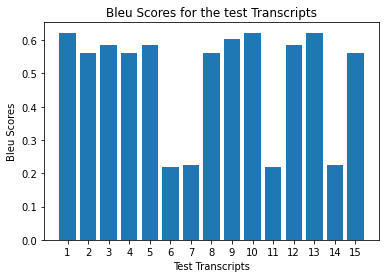

In [ ]:
# Generating a plot for the Bleu scores for the test transcripts
bleuScores, rougeScores = generateBleuScores(testTranscripts)
print("The bleu scores for test transcripts are: ", bleuScores)

testTranscriptsRange = list(range(1,len(testTranscripts)+1))
plt.xticks(range(len(bleuScores)), testTranscriptsRange)
plt.xlabel('Test Transcripts')
plt.ylabel('Bleu Scores')
plt.title('Bleu Scores for the test Transcripts')
plt.bar(range(len(bleuScores)), bleuScores) 
# plt.savefig('BleuScores.png')
plt.show()

In [ ]:
print("The Rouge score are as follows: ", rougeScores)

The Rouge score are as follows:  [{'rouge-1': {'f': 0.19999999555555567, 'p': 0.3, 'r': 0.15}, 'rouge-2': {'f': 0.0, 'p': 0.0, 'r': 0.0}, 'rouge-l': {'f': 0.13888888407793226, 'p': 0.1724137931034483, 'r': 0.11627906976744186}}, {'rouge-1': {'f': 0.13333332888888905, 'p': 0.2, 'r': 0.1}, 'rouge-2': {'f': 0.0, 'p': 0.0, 'r': 0.0}, 'rouge-l': {'f': 0.13888888407793226, 'p': 0.1724137931034483, 'r': 0.11627906976744186}}, {'rouge-1': {'f': 0.15555555111111127, 'p': 0.23333333333333334, 'r': 0.11666666666666667}, 'rouge-2': {'f': 0.0, 'p': 0.0, 'r': 0.0}, 'rouge-l': {'f': 0.13698629658097222, 'p': 0.1724137931034483, 'r': 0.11363636363636363}}, {'rouge-1': {'f': 0.13333332888888905, 'p': 0.2, 'r': 0.1}, 'rouge-2': {'f': 0.0, 'p': 0.0, 'r': 0.0}, 'rouge-l': {'f': 0.14285713800408179, 'p': 0.1724137931034483, 'r': 0.12195121951219512}}, {'rouge-1': {'f': 0.15555555111111127, 'p': 0.23333333333333334, 'r': 0.11666666666666667}, 'rouge-2': {'f': 0.0, 'p': 0.0, 'r': 0.0}, 'rouge-l': {'f': 0.179

In [ ]:
# Generating a tabular view to display Rouge scores for the test transcripts
import csv

with open('RougeScoreReport.csv', 'a') as file:
     writer = csv.writer(file)
     writer.writerow(["Transcript", " ", "Rouge-1", "  ", "   ", "Rouge-2", "    ", "       ", "Rouge-l", "          "])
     writer.writerow([" ", "f value", "p value", "r value", "f value", "p value", "r value", "f value", "p value", "r value"])
     no = 0;
     for temp in rougeScores:
       no +=1
       writer.writerow([no, temp["rouge-1"]["f"], temp["rouge-1"]["p"], temp["rouge-1"]["r"], temp["rouge-2"]["f"], temp["rouge-2"]["p"], temp["rouge-2"]["r"], temp["rouge-l"]["f"], temp["rouge-l"]["p"], temp["rouge-l"]["r"]])

In [ ]:
df = pd.read_csv("RougeScoreReport.csv")
blankIndex=[''] * len(df)
df.index=blankIndex
df

,Transcript,,Rouge-1,,,Rouge-2,,,Rouge-l,
,,f value,p value,r value,f value,p value,r value,f value,p value,r value
,1,0.19999999555555567,0.3,0.15,0.0,0.0,0.0,0.13888888407793226,0.1724137931034483,0.11627906976744186
,2,0.13333332888888905,0.2,0.1,0.0,0.0,0.0,0.13888888407793226,0.1724137931034483,0.11627906976744186
,3,0.15555555111111127,0.23333333333333334,0.11666666666666667,0.0,0.0,0.0,0.13698629658097222,0.1724137931034483,0.11363636363636363
,4,0.13333332888888905,0.2,0.1,0.0,0.0,0.0,0.14285713800408179,0.1724137931034483,0.12195121951219512
,5,0.15555555111111127,0.23333333333333334,0.11666666666666667,0.0,0.0,0.0,0.17910447270216096,0.20689655172413793,0.15789473684210525
,6,0.17777777333333344,0.26666666666666666,0.13333333333333333,0.022727268308368628,0.034482758620689655,0.01694915254237288,0.16901407967466786,0.20689655172413793,0.14285714285714285
,7,0.19999999555555567,0.3,0.15,0.022727268308368628,0.034482758620689655,0.01694915254237288,0.1643835568549448,0.20689655172413793,0.13636363636363635
,8,0.13333332888888905,0.2,0.1,0.0,0.0,0.0,0.14492753135895836,0.1724137931034483,0.125
,9,0.17777777333333344,0.26666666666666666,0.13333333333333333,0.0,0.0,0.0,0.17391303860533516,0.20689655172413793,0.15


# **Testing the Model**

#### Testing the Model with different number of transcripts and generated report as below

In [ ]:
import pandas as pd;

df = pd.read_csv("/content/drive/MyDrive/NLP/ModeltestReport_tSizes.csv")
blankIndex=[''] * len(df)
df.index=blankIndex
df

,TranscriptsSize,RandomSentence,PrefixSentence(they),BLEU Score
,30,today the first half the first half the georgi...,they can do that and the tigers are a good job...,0.218033
,50,today but i mean you know i don't want a lot a...,they were in the middle and i think you have t...,0.562341
,70,today and he was a freshman and you know you c...,they had a great play and he has to be the bes...,0.594548


# **Tuning the Model**

####  1)Tuning the Model with different number of HiddenUnits and generated report as below

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/NLP/HyperParameterReport_HiddenUnits.csv")
blankIndex=[''] * len(df)
df.index=blankIndex
df

,hiddenUnits,LearningRate,RandomSentence,PrefixSentence(they),BleuScore
,156,0.001,today for usc i don't think that is the first ...,they got a little high but you have the ball d...,0.432341
,256,0.001,today for this team that will have the ball an...,they were the best quarterback and the first d...,0.584435
,356,0.001,today in a game in this series and they were g...,they have a big win in the acc game of this se...,0.622333


####  2)Tuning the Model with different LearningRate and generated report as below

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/NLP/HyperParameterReport_LearningRate.csv")
blankIndex=[''] * len(df)
df.index=blankIndex
df

,hiddenUnits,LearningRate,RandomSentence,PrefixSentence(they),BleuScore
,256,0.010,today his the the the the a and the the and a ...,they the the and the the a and a the the a the...,0.562341
,256,0.050,today a the the to to to the the to the to a a...,they to to a a a to the to the the a a the a a...,0.584436
,256,0.001,today the ers were leading to the vikings and ...,they have to get it in the fourth half the ers...,0.654350
